# Análisis de modelos

En este código se realizó la construcción de dos modelos independientes para la predicción de los tipos de ataque, asociado con los resultados obtenidos en el primer análisis. El documento está dividido en los siguientes apartados:

* **Cargado de base de datos:** Carga de la base de datos previamente transformada y en formato parquet para su uso en los modelos.
* **Segmentación de datos por modelo:** División de los datos en diferentes conjuntos, específicos para cada uno de los modelos que se construirán.
* **Primer modelo:** Construido para los tipos de ataque con mayor número de registros
* **Segundo modelo:** Modelo con ataques restantes y una muestra de los casos benignos
* **Conclusiones y pasos futuros:** Análisis de los resultados obtenidos de los diferentes modelos y planificación de los siguientes pasos a seguir.

# 1. Cargado de Base

Se utilizó la base de **CIC-DDoS2019**, que se carga a continuación junto con las demas librerías, que son las mismas del ejercicio de XGBoost:

In [ ]:
# Montado de drive para realizar el análisis
from google.colab import drive
drive.mount('/content/drive')
#Librerías Utilizadas
import pandas as pd # Manipulación de datos
pd.options.display.float_format = '{:.1f}'.format # Adecuar formato de salidas de tablas a 1 posición decimal
import seaborn as sns # Creación de gráficas
import matplotlib.pyplot as plt # Formato de gráficas
import numpy as np
# Herramientas de análisis de modelos
from sklearn.model_selection import train_test_split, GridSearchCV # Creación set entrenamiento - validación
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score # Medición de precisión
from sklearn.preprocessing import LabelEncoder
# Librerías modelo XGbost
from xgboost import XGBClassifier # Modelo a entrenar
from xgboost import plot_importance # Gráfica para ver pesos de las variables

Mounted at /content/drive


Con estas librerías se realizó el cargue de la información, que corresponde a 431371 filas y 39 columnas y donde no hay valores nulos:

In [ ]:
df_CIC2019_corr = pd.read_parquet("/content/drive/MyDrive/Tesis - Machine Learning/Tesis - Machine Learning/E - Modelo predicción/Base/CICIDS2019_2.parquet")

In [ ]:
df_CIC2019_corr.head(5)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Flow Bytes/s,Flow Packets/s,Fwd PSH Flags,Fwd Header Length,...,Fwd Seg Size Min,Label,Packet Length Mean,Fwd Packet Length Mean,Active Mean,Fwd IAT Mean,Idle Mean,Bwd IAT Mean,Bwd Packet Length Mean,Flow IAT Mean
0,17,48,4,0,1616.0,0.0,33666666.7,83333.3,0,80,...,20,DrDoS_NTP,411.2,404.0,0.0,16.0,0.0,0.0,0.0,16.0
1,17,557,112,0,49280.0,0.0,88473967.7,201077.2,0,0,...,0,DrDoS_NTP,440.0,440.0,0.0,5.0,0.0,0.0,0.0,5.0
2,6,323228,14,12,1736.0,526.0,6998.2,80.4,0,304,...,20,Benign,83.8,124.0,0.0,24863.7,0.0,15038.7,43.8,12929.1
3,17,46917,2,2,86.0,118.0,4348.1,85.3,0,40,...,20,Benign,49.4,43.0,0.0,3.0,0.0,2.0,59.0,15639.0
4,17,254,58,0,25520.0,0.0,100472440.9,228346.5,0,-58,...,-1,DrDoS_NTP,440.0,440.0,0.0,4.5,0.0,0.0,0.0,4.5


# 2. Segmentación de datos por modelo

De acuerdo con los resultados obtenidos en análisis previos, se construyó el conteo de registros asociados a cada tipo de ataque. Cabe aclarar que estos provienen de la base previamente tratada en la que se agruparon los ataques de acuerdo con puntos en común en el nombre y comportamiento:

In [ ]:
df_CIC2019_corr.groupby("Label").count()["Protocol"].sort_values(ascending=False)

Label
DrDoS_NTP     121368
TFTP           98917
Benign         97831
Syn            49373
UDP            37437
MSSQL          14735
DrDoS_DNS       3669
LDAP            3346
DrDoS_SNMP      2717
NetBIOS         1242
Portmap          685
WebDDoS           51
Name: Protocol, dtype: int64

Se identificó que dentro de los 12 ataques, el de mayor registro corresponde a `DrDoS_NTP` con 121368, mientras que el mínimo es `WebDDoS` con sólo 51 registros. Por ello se organizaron 2 bases de datos filtradas:

1. La primera agrupa los ataques con mayores registros (DrDoS_NTP, TFTP, Syn, UDP y MSSQL) en conjunto con los registros benignos
2. En la segunda están los demás en conjunto con una muestra de 2000 registros de los casos benignos, ya que el objetivo es diferenciar si un proceso corresponde a un ataque.

In [ ]:
# Ataques con mayor número de registros
filt_1 = ["DrDoS_NTP", "TFTP", "Benign", "Syn","UDP", "MSSQL"]
# Ataques con menor número de registros
filt_2 = ["DrDoS_DNS", "LDAP", "DrDoS_SNMP", "NetBIOS", "Portmap", "WebDDoS"]
df_1=df_CIC2019_corr[df_CIC2019_corr["Label"].isin(filt_1)]
df_2=df_CIC2019_corr[df_CIC2019_corr["Label"].isin(filt_2)]
# Muestra de los benignos
df_temp=df_1[df_1["Label"]=="Benign"][:2000]
df_2=pd.concat([df_2,df_temp],axis=0)

# Entrenamiento primer modelo

Para este primer modelo, se realizó el proceso de creación del dataset de entrenamiento y prueba, a partir de la librería de Scikit-learn con una proporción de 80/20:

In [ ]:
# Variables a entrenar
X1 = df_1.drop(columns="Label")
# Variable objetivo - sospechosos
le = LabelEncoder()
#Conversión de texto a numero
encoded = le.fit_transform(df_1["Label"])
y = encoded
# División entrenamiento - rest con ratio de 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

Con esta información, se entrenó un modelo de XGBoost, ya que fue el que mejor desempeño tuvo en las pruebas anteriores y tiene un bajo tiempo de ejecución. Si se usa una GPU (NVIDIA Tesla T4 en el entorno de Google Colab) el tiempo de ejecución es cercano a los 7 segundos.

In [ ]:
%%time
clf = XGBClassifier(tree_method = "hist", device = "cuda").fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:02:24] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


CPU times: user 1min 14s, sys: 759 ms, total: 1min 15s
Wall time: 1min 11s


Luego se calcularon las principales métricas de desempeño utilizadas para el desarrollo del proyecto: precisión, recall y f1-score. A diferencia del modelo consolidado anterior, se alcanza un porcentaje de 99.6% en las tres métricas, mostrando una mejora significante en el desempeño del modelo sin requerir un proceso de optimización de los hiperparámetros como se examinó en ejercicios anteriores:


In [ ]:
# Predicción
y_model = clf.predict(X_test)
#Precisión
acc = accuracy_score(y_test,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

Precisión: 0.9958300072677017
Recall: 0.9958300072677017
F1 score: 0.9958443718716408


Al ver el detalle de las métricas por tipo de ataque, se identificó que en todas se supera el 97%, excepto en los dos modelos que tienen menor cantidad de registros con respecto a los demás y los benignos:

In [ ]:
print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19623
           1       1.00      1.00      1.00     24196
           2       0.96      0.98      0.97      2866
           3       1.00      0.99      1.00      9961
           4       1.00      1.00      1.00     19807
           5       0.98      0.98      0.98      7480

    accuracy                           1.00     83933
   macro avg       0.99      0.99      0.99     83933
weighted avg       1.00      1.00      1.00     83933



Esto se ve reflejado en la matriz de confusión, donde la predicción de todos los modelos es cercana al 100%, es decir, que predice casi a la perfección si un registro corresponde a un caso benigno o a algún tipo de ciberataque.

<Axes: >

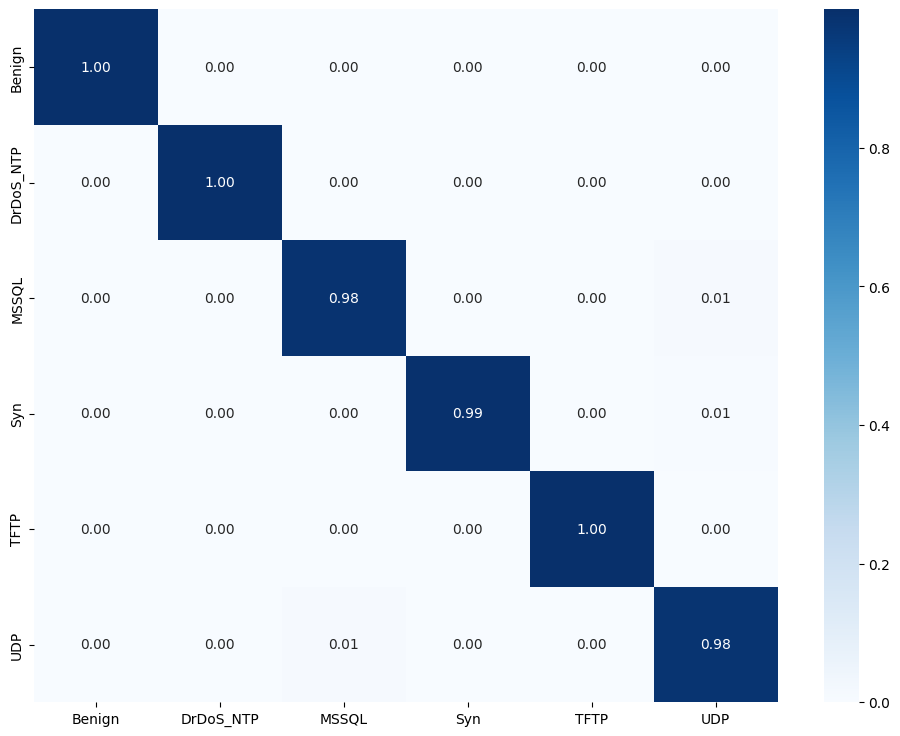

In [ ]:
# Matriz Normalizada
plt.figure(figsize=(12,9))
cm=confusion_matrix(y_test, y_model)
# Proceso de normalización
cm_normalized= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized,annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

En cuanto a la importancia, se identificó que la variable de `Fwd Header Lenght` es la que tiene un mayor peso en la predicción, seguida por `Flow Duration`. Estas variables serán de referencia para la comparación con el siguiente modelo.

<Figure size 1500x900 with 0 Axes>

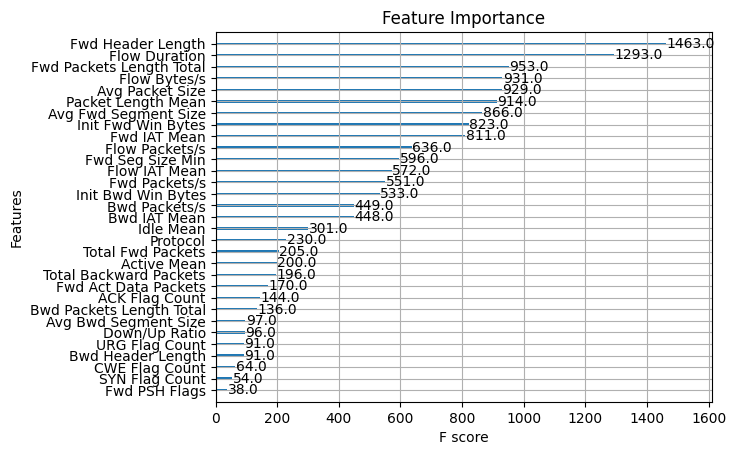

In [ ]:
# Graficar la importancia de las variables
plt.figure(figsize=(15, 9))
plot_importance(clf, importance_type='weight')
plt.title('Feature Importance')
plt.show()


# Entrenamiento segundo modelo

Para este modelo se realizó el mismo proceso de entrenamiento que el primero, donde se dividió la información en proporción de 80/20:

In [ ]:
# Variables a entrenar
X1 = df_2.drop(columns="Label")
# Variable objetivo - sospechosos
le = LabelEncoder()
#Conversión de texto a numero
encoded = le.fit_transform(df_2["Label"])
y = encoded
# División entrenamiento - rest con ratio de 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

La ejecución del modelo de XGBoost se completó en 5 segundos, dado que la cantidad de información es menor:

In [ ]:
%%time
clf = XGBClassifier(tree_method = "hist", device = "cuda").fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:03:32] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


CPU times: user 3.79 s, sys: 32.2 ms, total: 3.82 s
Wall time: 2.04 s


No obstante, al calcular las métricas base de los modelos, se identificó que esta se reducen a un 74%, lo que indica que para la predicción de este conjunto de ciberataques se enfrentan dificultades y puede ser necesario realizar otro tipo de modelamiento:


In [ ]:
y_model = clf.predict(X_test)
#Precisión
acc = accuracy_score(y_test,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

Precisión: 0.7439824945295405
Recall: 0.7439824945295405
F1 score: 0.7433623459849469


Esto se ve reflejado en la matriz de confusión, donde hay ciberataques como el de `portmap` donde sólo se etiqueta correctamente el 50% de los registros. Le sigue el caso de `DrDoS_DNS` con un 66%.

<Axes: >

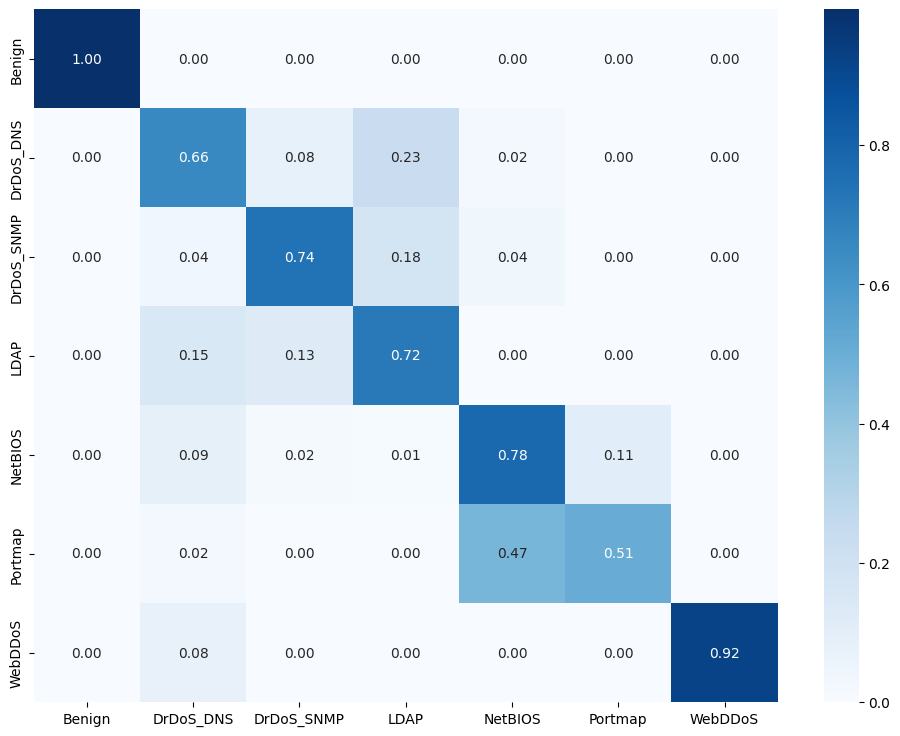

In [ ]:
# Matriz Normalizada
plt.figure(figsize=(12,9))
cm=confusion_matrix(y_test, y_model)
# Proceso de normalización
cm_normalized= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized,annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

Esto se refleja en el análisis por modelo, donde las métricas, a excepción del caso benigno, son menores a las registradas en el primer modelo. Esto a su vez representa el peso que tuvieron estos ataques en las métricas del modelo de referencia, ya que de forma similar redujeron la precisión total.

In [ ]:
print(classification_report(y_test, y_model))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       409
           1       0.76      0.66      0.71       728
           2       0.72      0.74      0.73       511
           3       0.65      0.72      0.68       694
           4       0.66      0.78      0.71       253
           5       0.68      0.51      0.58       134
           6       0.92      0.92      0.92        13

    accuracy                           0.74      2742
   macro avg       0.77      0.76      0.76      2742
weighted avg       0.75      0.74      0.74      2742



Adicional, en la métrica de importancia de las variables se identificó una distribución diferente con respecto al modelo anterior: `Flow duration` baja al 4to lugar de importancia, mientras que `Flow Bytes/s` sube al segundo. Esto muestra que hay una diferencia en la significancia de las variables en el modelo comparado con el anterior.

<Figure size 1500x900 with 0 Axes>

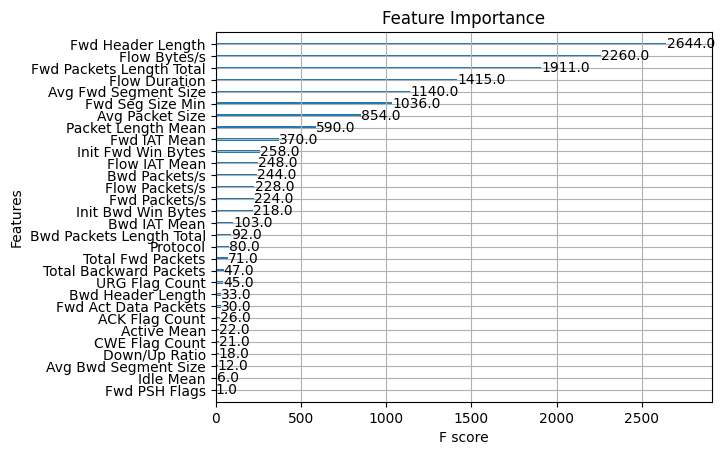

In [ ]:
# Graficar la importancia de las variables
plt.figure(figsize=(15, 9))
plot_importance(clf, importance_type='weight')
plt.title('Feature Importance')
plt.show()


# Comentarios finales y siguientes pasos

En el análisis de estos modelos se observó una mejora en la clasificación al implementar dos modelos separados para diferentes tipos de ataques, aunque para aquellos con menor cantidad de registros, el cambio no fue tan significativo. Por lo tanto, se concluye que la mejor estrategia para predecir estos ataques es utilizar ambos modelos en conjunto, aprovechando así las fortalezas de cada uno y mejorando la precisión general.

Esta estrategia se ve facilitada por el tamaño de los modelos, sus tiempos de ejecución y la facilidad de uso de la información. Estos pasos no solo mejoran la capacidad predictiva, sino que también proporcionan insights valiosos para la toma de decisiones en la gestión y prevención de ciberataques.